# Prediction of tram delays in Cracow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import eli5
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

2023-04-03 23:22:17.389850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 23:22:17.658413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 23:22:17.658437: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-03 23:22:18.674550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
df_1 = pd.read_hdf('tram.train.h5')
df_2 = pd.read_hdf('tram.test.h5')

print(df_1.shape, df_2.shape)

(175986, 11) (132166, 9)


## Concat datasets and leaving delay columns separated

Concatting `df_train` with ` df_test` and signing it to `df`.

In [6]:
delay = df_1['delay']
#df_train.drop('delay', axis=1, inplace=True) #Leaving y label - delay unchanged
delay

0           0
1           0
2           0
3           0
4           0
         ... 
308147      0
308148    660
308149    660
308150    660
308151    660
Name: delay, Length: 175986, dtype: int64

In [7]:
df = pd.concat([df_1, df_2])
df.shape

(308152, 11)

In [9]:
df.sample(5)

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
12595,12595,120.0,2018-07-23 10:22:19,78,Batorego,24,Bronowice Małe,2018-07-23 10:20:00,6.352185e+18,6351558574044961030,19.0
249810,249810,180.0,2018-07-30 16:58:07,570,Plac Bohaterów Getta,24,Kurdwanów P+R,2018-07-30 16:52:00,6.352185e+18,6351558574044930061,18.0
16951,16951,60.0,2018-07-23 11:59:25,61,Bratysławska,50,Krowodrza Górka,2018-07-23 11:58:00,6.352185e+18,6351558574044997900,17.0
205483,205483,0.0,2018-07-27 16:24:59,126,Lubicz,52,Czerwone Maki P+R,2018-07-27 16:24:00,6.352185e+18,6351558574046891274,18.0
99036,99036,0.0,2018-07-25 07:40:38,2539,Rondo Hipokratesa,14,Bronowice Małe,2018-07-25 07:40:00,6.352185e+18,6351558574044723972,6.0


In [10]:
# Example of a one trip
df[df['trip_id']==6351558574044977929]

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
120757,120757,0.0,2018-07-25 15:56:56,450,Kopiec Wandy,44,Bronowice,2018-07-25 15:58:00,6.352185e+18,6351558574044977929,1.0
121014,121014,60.0,2018-07-25 16:02:42,459,Kombinat,44,Bronowice,2018-07-25 16:01:00,6.352185e+18,6351558574044977929,2.0
121235,121235,60.0,2018-07-25 16:08:05,423,Struga,44,Bronowice,2018-07-25 16:07:00,6.352185e+18,6351558574044977929,3.0
121415,121415,60.0,2018-07-25 16:12:07,2744,Plac Centralny im. R.Reagana,44,Bronowice,2018-07-25 16:11:00,6.352185e+18,6351558574044977929,4.0
121475,121475,60.0,2018-07-25 16:13:23,413,Os.Kolorowe,44,Bronowice,2018-07-25 16:12:00,6.352185e+18,6351558574044977929,5.0
121606,121606,0.0,2018-07-25 16:16:21,408,Rondo Czyżyńskie,44,Bronowice,2018-07-25 16:16:00,6.352185e+18,6351558574044977929,6.0
121711,121711,0.0,2018-07-25 16:18:29,112,Stella-Sawickiego,44,Bronowice,2018-07-25 16:18:00,6.352185e+18,6351558574044977929,8.0
121815,121815,60.0,2018-07-25 16:21:13,2811,Muzeum Lotnictwa,44,Bronowice,2018-07-25 16:20:00,6.352185e+18,6351558574044977929,10.0
121889,121889,0.0,2018-07-25 16:22:52,3040,TAURON Arena Kraków Wieczysta,44,Bronowice,2018-07-25 16:23:00,6.352185e+18,6351558574044977929,11.0
121946,121946,0.0,2018-07-25 16:24:09,130,Białucha,44,Bronowice,2018-07-25 16:24:00,6.352185e+18,6351558574044977929,12.0


Mean: 61.5168252020047
max: 1140
min: 0
std: 82.48747691648444
Q_1: 0.0
Median: 60.0
Q_3: 120.0
Odległość abbsolutna miedzy Q_1 i Q_3: 120.0


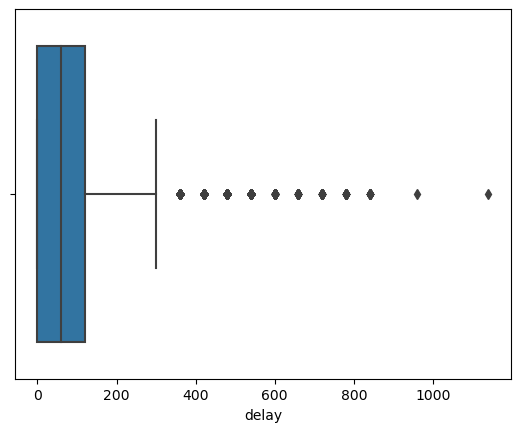

In [11]:
from scipy.stats import iqr

mean = np.mean(delay)
max = np.max(delay)
min = np.min(delay)
std = np.std(delay)
q_1 = np.quantile(delay, .25)
median = np.quantile(delay, .50)
q_3 = np.quantile(delay, .75)
iqr = iqr(delay) #odleglosc absolutna miedzy Q_1 i Q_3

print('Mean: {}'.format(mean))
print('max: {}'.format(max))
print('min: {}'.format(min))
print('std: {}'.format(std))
print('Q_1: {}'.format(q_1))
print('Median: {}'.format(median))
print('Q_3: {}'.format(q_3))
print('Odległość abbsolutna miedzy Q_1 i Q_3: {}'.format(iqr))

import seaborn as sns

sns.boxplot(x=delay)
plt.show()

### Dealing with features (`feature engineering`)

Krakow is one of the largest cities in Poland, which can result in streetcar delays caused by rush hour - when there are longer waits for public transportation.There are different dynamics during rush hour.

A hypothesis arises to show the model directly what time it is. <strong> We pull this hour from `planned_time` - the variable tells us what time the planned tram ride was. </strong>

Using `pd.to_datetime` we map planned_time to a datetime type, which allows us to work with dates more easily.

In [12]:
df.drop('id', axis=1, inplace=True)

In [13]:
df['planned_time'] = pd.to_datetime(df['planned_time'], format='%Y-%m-%d %H:%M:%S')
df['day'] = df['planned_time'].dt.dayofweek

df['month'] = df['planned_time'].dt.month

df['hour'] = df['planned_time'].dt.hour

df['minute'] = df['planned_time'].dt.minute


In [14]:
df['stop_diff'] = df['stop'].diff()


if (df['hour'] == 0).any():
    df['stop_hour'] = 0
else:
    df['stop_hour'] = df['stop'] / df['hour']
    

df['rush_hours'] = df['hour'].apply(lambda x: 1 if (x > 5 and x < 10) | (x > 14 and x < 19) else 0) # rush_hours
df['night_hours'] = df['hour'].apply(lambda x: 1 if (x < 6 or x > 21) else 0) # night_hours

In [15]:
df['vehicle_id_log'] = df['vehicle_id'].map(lambda x: np.log(x))

df['vehicle_id_cat'] = pd.factorize(df['vehicle_id_log'])[0]

In [16]:
len(df['planned_time'].unique()) 

# planned_time columns is not needed any more
#I used this column to extract every possible information 
#such as day, month, hour, minute and so on.

df.drop('planned_time', axis=1, inplace=True)

##### Bus stops
There are probably some streetcar stops that are more frequently used and prone to delay.
For extracting more data, you can collect more information about delays occurring at specific stops (e.g., average value, standard deviation).
Let's also count how often no delay occurred at a particular stop (zero delay) - `count_zeros_stopname_delay`.

In [17]:
def df_group_delay(df_train, groupby_feats):
    agg_params = {
        "mean_{}_delay".format("_".join(groupby_feats)): ("delay", "mean"),
        "median_{}_delay".format("_".join(groupby_feats)): ("delay", "median"),
        "count_{}_delay".format("_".join(groupby_feats)): ("delay", "count"),
        "std_{}_delay".format("_".join(groupby_feats)): ("delay", "std"),
        "count_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: len([x for x in vals if x == 0]) ),
        "prob_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
    }
    
    return df_train[groupby_feats + ["delay"]].groupby(groupby_feats).agg(**agg_params).reset_index()

##### Converting object columns into dummies columns

In [18]:
df.select_dtypes('object')

,stop_name,direction
0,Borsucza,Walcownia
1,Smolki,Czerwone Maki P+R
2,Filharmonia,Bronowice Małe
3,Hala Targowa,Salwator
4,Batorego,Bronowice Małe
...,...,...
308141,Bronowice,Bronowice Małe
308142,Kampus UJ,Czerwone Maki P+R
308143,Wesele,Bronowice Małe
308144,Bieżanowska,Kurdwanów P+R


In [19]:
print(df['direction'].value_counts(), '\n')

direction = pd.get_dummies(df['direction'], prefix = 'direction', drop_first=True)

df.drop('direction', axis=1, inplace=True)

Czerwone Maki P+R    36743
Bronowice Małe       35937
Krowodrza Górka      35372
Nowy Bieżanów P+R    22648
Wzgórza K.           22416
Borek Fałęcki        18488
Kurdwanów P+R        18293
Os.Piastów           18169
Salwator             16224
Mistrzejowice        15089
Mały Płaszów         13517
Bronowice            10259
Prokocim              9296
Kopiec Wandy          7965
Cichy Kącik           7480
Walcownia             6276
Łagiewniki            5410
Dworzec Tow.          5393
Cm. Rakowicki         1788
Kombinat              1389
Name: direction, dtype: int64 



In [20]:
print(df['stop_name'].value_counts(), '\n')

stop_name = pd.get_dummies(df['stop_name'], prefix = 'stop_name', drop_first=True)

df.drop('stop_name', axis=1, inplace=True)

Rondo Mogilskie                            6766
Dworzec Główny                             6699
Stradom                                    5062
Rondo Grzegórzeckie                        5004
Kabel                                      4800
Starowiślna                                4755
Rondo Czyżyńskie                           4516
Bieżanowska                                4318
Podgórze SKA                               4315
Teatr Bagatela                             4289
Stary Kleparz                              4131
Poczta Główna                              4131
Lubicz                                     4126
Dworzec Towarowy                           3722
Dworcowa                                   3674
Filharmonia                                3592
Korona                                     3571
Cmentarz Podgórski                         3564
Biprostal                                  3515
Bratysławska                               3454
Plac Wszystkich Świętych                

In [21]:
len(df['datetime'].unique()) 

# datatime column contains np.nan values when delay column (y label column) is also np.nan
# delay column is the result of subtraction between planned_time column and datatime column

df.drop('datetime', axis=1, inplace=True)

## Dealing with NaN Values

['seq_num', 'stop_diff']


<AxesSubplot:>

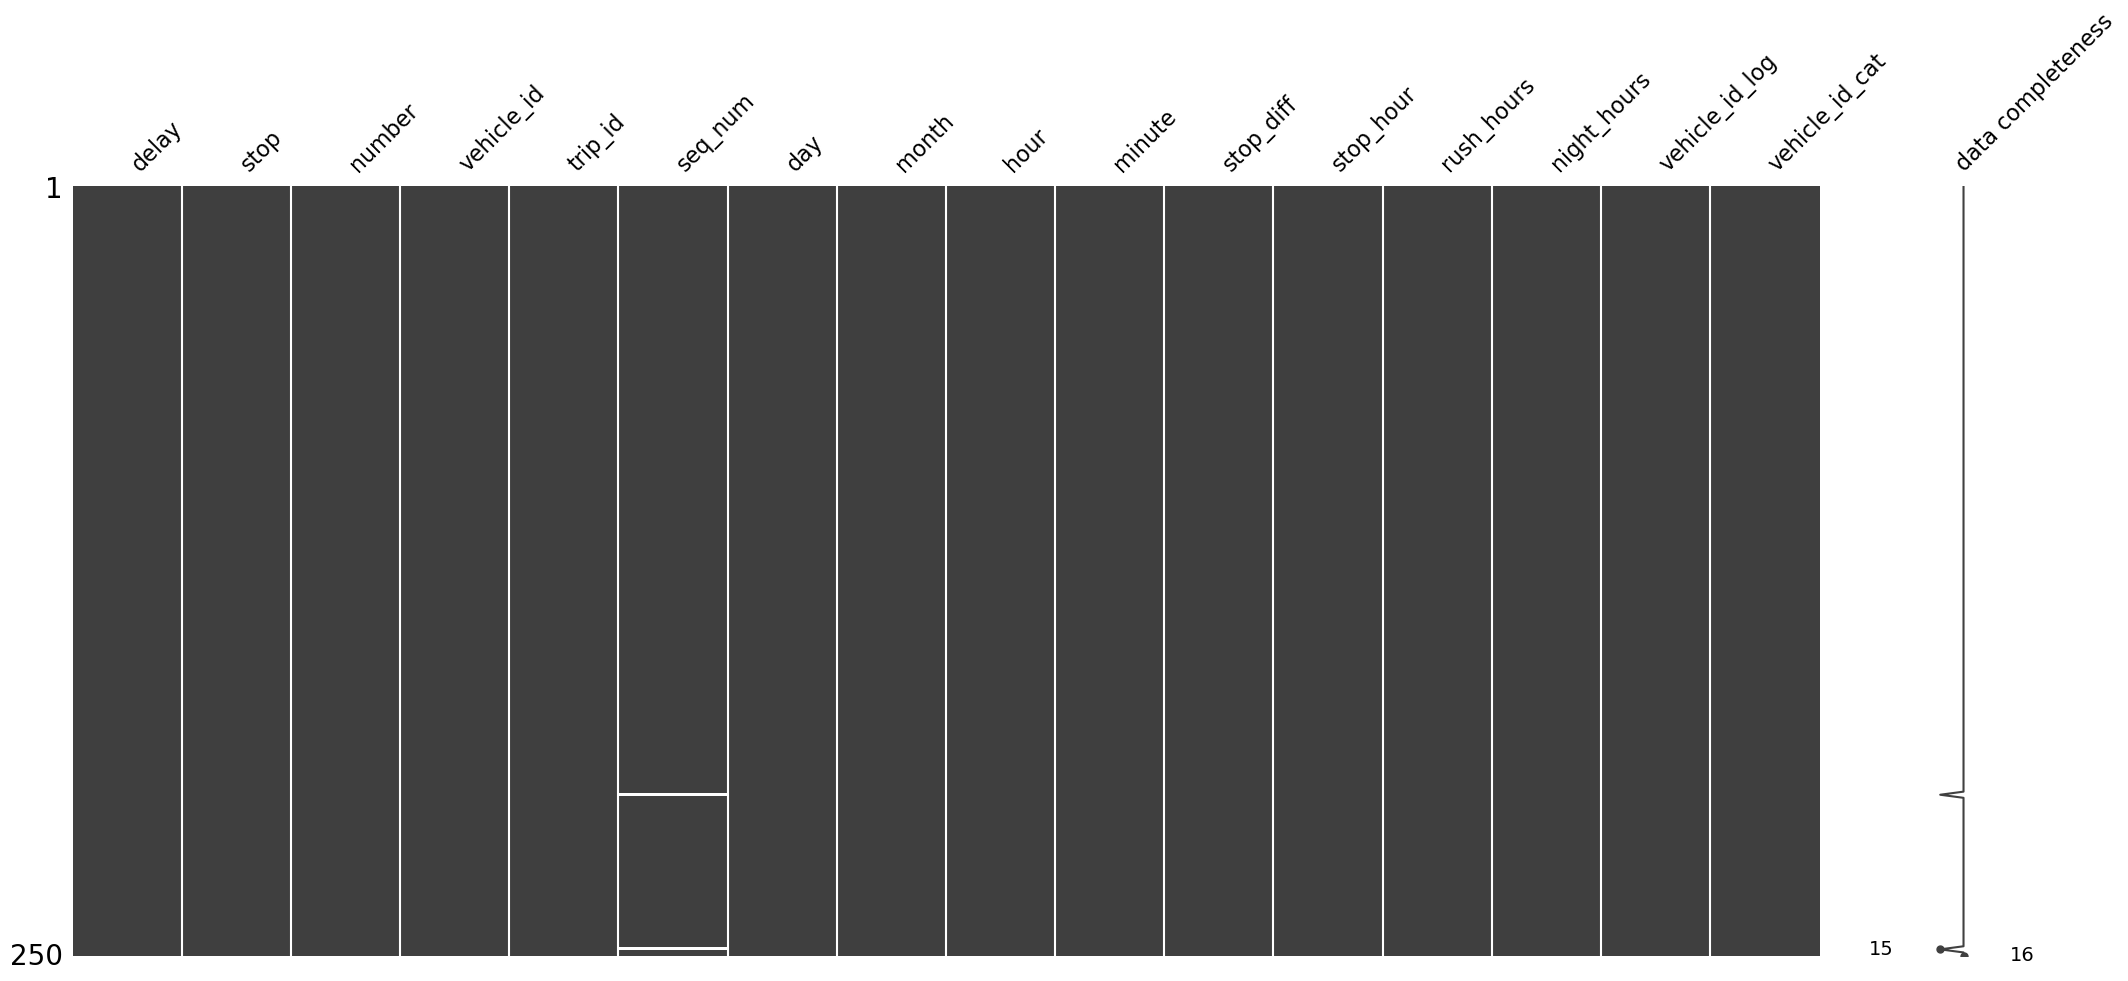

In [22]:
import missingno as msno

print(df.columns[df.isna().any()].tolist())
msno.matrix(df.sample(250), labels=True)

In [23]:
df['seq_num'] = df['seq_num'].interpolate()

In [24]:
df['stop_diff'] = df['stop_diff'].fillna(method='bfill')

In [25]:
print(df.columns[df.isna().any()].tolist())
print(df.info())

[]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 308152 entries, 0 to 308145
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   delay           308152 non-null  float64
 1   stop            308152 non-null  int64  
 2   number          308152 non-null  int64  
 3   vehicle_id      308152 non-null  float64
 4   trip_id         308152 non-null  int64  
 5   seq_num         308152 non-null  float64
 6   day             308152 non-null  int64  
 7   month           308152 non-null  int64  
 8   hour            308152 non-null  int64  
 9   minute          308152 non-null  int64  
 10  stop_diff       308152 non-null  float64
 11  stop_hour       308152 non-null  int64  
 12  rush_hours      308152 non-null  int64  
 13  night_hours     308152 non-null  int64  
 14  vehicle_id_log  308152 non-null  float64
 15  vehicle_id_cat  308152 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 48.0 MB
None


## Select features

In addition, we can ignore some features, because if you check them more carefully, it turns out that they do not contribute much.

In [27]:
df['delay'] = delay

y = df['delay'].dropna()

X = df[~df['delay'].isna()]
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_numeric = X[numeric_cols]
X.drop('delay', axis=1, inplace=True)

X_test = df[df['delay'].isna()]
X_test.drop('delay', axis=1, inplace=True)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, )

(114390, 15) (61596, 15) (114390,) (61596,)


## Building the model

<strong>Due to the large amount of data/records, most of the models available in scikit-learn will not be able to learn the model!</strong> For that, we can still use the capabilities of the XGBoost library.

##### Creating first models

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_r = GradientBoostingRegressor()

gradient_r.fit(X_train,y_train)

y_pred_train = gradient_r.predict(X_train)
y_pred_valid = gradient_r.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 52.81401917287743
MAE on valid dataset: 52.82283613525589


In [54]:
from sklearn.ensemble import AdaBoostRegressor #Adaptive Boosting
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
ada_rfr = AdaBoostRegressor(base_estimator=rfr)

ada_rfr.fit(X_train,y_train)

y_pred_train = ada_rfr.predict(X_train)
y_pred_valid = ada_rfr.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 64.1749234905406895
MAE on valid dataset: 70.092853506511886


In [32]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_valid = xgb_model.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 45.599538905406895
MAE on valid dataset: 47.96853706511886


##### Hyperparameter tuning on the XGBRegressor

In [33]:
from sklearn.model_selection import RandomizedSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=123)

params_xgbr = {'n_estimators': np.arange(50,350,50),
          'max_depth': [2,3,4,5,6],
         'learning_rate':[0.01,0.1,0.5,0.9],
         'subsample':[0.3,0.5,0.9]}

In [46]:
xgbr = xgb.XGBRegressor()

xgbr_cv = RandomizedSearchCV(xgbr, params_xgbr, cv=kf, n_jobs=-1)

xgbr_cv.fit(X_train,y_train)

y_pred_train = xgbr_cv.predict(X_train)
y_pred_valid = xgbr_cv.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 28.892229052740117
MAE on valid dataset: 31.043666506984472


##### Cross validation on the XGBRegressor

In [50]:
from sklearn.model_selection import cross_val_score

xgbr_hp = xgbr_cv.best_model_

scores = cross_val_score(xgbr_hp, X_train, y_train, cv=20, scoring="neg_mean_absolute_error")

print('mean of cross validation: {}'.format(-scores.mean()))
print('std of cross validation: {}'.format(scores.std()))

mean of cross validation: 31.462089456203035
std of cross validation: 0.06042392804400001


In [51]:
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 50,20
xgb.plot_tree(xgbr_hp, num_trees=2)
plt.savefig('plot_tree.png')

In [52]:
rcParams['figure.figsize'] = 50,20
xgb.plot_importance(xgbr_hp)
plt.savefig('plot_importance.png')